# Questão 3 - Clusterização

Execute os algoritmos de agrupamento K-means e Hierárquico com diferentes valores de clusters e escolha o melhor resultado.
 
 
Para o hierárquico, varie entre o single e complete linkage e analise os resultados obtidos.
Para o k-means, inicialize os centroides aleatoriamente e avalie o impacto da inicialização nos resultados encontrados.
 
 
<b>Bônus</b>: normalizar os dados e executar novamente os algoritmos para analisar os resultados gerados.
Fazer visualização dos clusters encontrados com PCA ou t-SNE.

## Preliminares
Importação de dependências, carregamento da base de dados e observação inicial dos dados.

In [35]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster
from sklearn import model_selection
from sklearn import metrics

In [18]:
df = pd.read_csv('Live.csv', delimiter = ',') # Abrir base de dados

df.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


Uma análise inicial indica que as colunas 'Column1', 'Column2', 'Column3' e 'Column4' não contém alguma informação.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 16 columns):
status_id           7050 non-null object
status_type         7050 non-null object
status_published    7050 non-null object
num_reactions       7050 non-null int64
num_comments        7050 non-null int64
num_shares          7050 non-null int64
num_likes           7050 non-null int64
num_loves           7050 non-null int64
num_wows            7050 non-null int64
num_hahas           7050 non-null int64
num_sads            7050 non-null int64
num_angrys          7050 non-null int64
Column1             0 non-null float64
Column2             0 non-null float64
Column3             0 non-null float64
Column4             0 non-null float64
dtypes: float64(4), int64(9), object(3)
memory usage: 881.4+ KB


Para se ter certeza desta observação, verifica-se a quantia de dados faltantes em cada coluna:

In [20]:
df.isnull().sum()

status_id              0
status_type            0
status_published       0
num_reactions          0
num_comments           0
num_shares             0
num_likes              0
num_loves              0
num_wows               0
num_hahas              0
num_sads               0
num_angrys             0
Column1             7050
Column2             7050
Column3             7050
Column4             7050
dtype: int64

De fato estas 4 colunas não contém nenhuma informação, e portanto serão descartadas:

In [21]:
df.drop(columns = ['Column1', 'Column2', 'Column3', 'Column4'], inplace = True)

Após eliminar estas quatro colunas não restam atributos faltando, contudo ainda é necessário analisar melhor os atributos que não estão em formato numérico: 'status_id', 'status_type' e 'status_published', uma vez que é necessária fazer a conversão destes para poder serem usados pelo algoritmo de aprendizagem de máquina.

## Tratando atributos não numéricos

In [22]:
unique = df['status_id'].unique()
print("Valores únicos de status_id:", unique, "\nTamanho:", len(unique), "\n")
unique = df['status_type'].unique()
print("Valores únicos de status_type:", unique, "\nTamanho:", len(unique), "\n")
unique = df['status_published'].unique()
print("Valores únicos de status_published:", unique, "\nTamanho:", len(unique))

Valores únicos de status_id: ['246675545449582_1649696485147474' '246675545449582_1649426988507757'
 '246675545449582_1648730588577397' ...
 '1050855161656896_1060126464063099' '1050855161656896_1058663487542730'
 '1050855161656896_1050858841656528'] 
Tamanho: 6997 

Valores únicos de status_type: ['video' 'photo' 'link' 'status'] 
Tamanho: 4 

Valores únicos de status_published: ['4/22/2018 6:00' '4/21/2018 22:45' '4/21/2018 6:17' ... '9/21/2016 23:03'
 '9/20/2016 0:43' '9/10/2016 10:30'] 
Tamanho: 6913


O atributo status_type é o que possui a menor cardinalidade entre os atributos não numéricos, podendo assumir 4 valores diferentes.

Enquanto o atributo status_published, apesar de ter vários valores distintos, aparenta se tratar da data e hora no qual uma publicação foi realizada, esta informação poderia ser dividida em mais atributos.

Por fim, o status_id possui uma alta cardinalidade, pelo ver, este atributo parece conter um código identificador para cada publicação, contudo, não é possível garantir isso ainda, pois existem pelo menos um valor distinto deste atributo que ocorre mais de uma vez nesta base de dados.

### status_type
Este atributo é do tipo categórico e deve ser convertido para númerico usando one-hot encoding:

In [23]:
oh = pd.get_dummies(df['status_type'])

df = df.drop(columns = ['status_type'])

df = df.join(oh)

df.head()

,status_id,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,link,photo,status,video
0,246675545449582_1649696485147474,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,0,0,0,1
1,246675545449582_1649426988507757,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,0,1,0,0
2,246675545449582_1648730588577397,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,0,0,0,1
3,246675545449582_1648576705259452,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,0,1,0,0
4,246675545449582_1645700502213739,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,0,1,0,0


### status_published
Este atributo contém informações sobre a data e hora de uma publicação, então pode ser dividida em outros atributos, no caso serão criados os atributos 'day', 'month', 'year' e 'time' a partir do atributo original, sendo que 'time' será medido em minutos, com o propósito de combinar as horas com os minutos em uma coluna apenas.

In [24]:
dt = df['status_published'].to_list()
times = []
years = []
months = []
days = []

for d in dt:
    split = d.split(" ")
    split2 = split[0].split("/")
    
    years.append(int(split2[0]))
    months.append(int(split2[1]))
    days.append(int(split2[2]))
    
    split2 = split[1].split(':')
    times.append((int(split2[0]) * 60 + int(split2[1])))
    
dt_df = pd.DataFrame({"day": days, "month": months, "year": years, "time": times})

df = df.join(dt_df)
df.drop(columns = ['status_published'], inplace = True)

df.head()

,status_id,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,link,photo,status,video,day,month,year,time
0,246675545449582_1649696485147474,529,512,262,432,92,3,1,1,0,0,0,0,1,2018,22,4,360
1,246675545449582_1649426988507757,150,0,0,150,0,0,0,0,0,0,1,0,0,2018,21,4,1365
2,246675545449582_1648730588577397,227,236,57,204,21,1,1,0,0,0,0,0,1,2018,21,4,377
3,246675545449582_1648576705259452,111,0,0,111,0,0,0,0,0,0,1,0,0,2018,21,4,149
4,246675545449582_1645700502213739,213,0,0,204,9,0,0,0,0,0,1,0,0,2018,18,4,202


### status_id
Este atributo não me aparenta ter alguma utilidade original, imagino que se trata do valor identificador para uma publicação, contudo, darei uma segunda chance para este mostrar seu valor.

Como os valores deste atributo estão separados por um '_', vejamos como a parte direita deste atributo se relaciona a parte esquerda:

In [25]:
dt = df['status_id'].to_list()
left = []
right = []

for d in dt:
    split = d.split("_")
    left.append(split[0])
    right.append(split[1])

lr_df = pd.DataFrame({"left_status_id": left, "right_status_id": right})

df = df.join(lr_df)
df.drop(columns = ['status_id'], inplace = True)

print("Quantidade de valores únicos para left_status_id:" ,len(df['left_status_id'].unique()))

Quantidade de valores únicos para left_status_id: 9


O número de valores únicos para a parte esquerda é bastante baixo, contudo, não é possível fazer alguma conclusão sobre isso pelo fato de que talvez os valores atribuídos para a coluna 'status_id' original não sigam alguma ordem lógica (e.g. tenham sido gerados por alguma função de dispersão). 

Para tentar adquirir mais informações, com o propósito de facilitar a decisão a ser tomada em relação a este atributo, vejamos como os dois novos atributos se relacionam:

In [26]:
unique = df['right_status_id'].unique()
print("Valores únicos de right_status_id: ", len(unique))

for unique_right in unique:
    loc = df.loc[df['right_status_id'] == unique_right]
    matches = loc['left_status_id'].unique()
    if(len(matches) > 1): 
        print("left_status_id para", unique_right, ":", matches, "\nQuantidade: ", len(matches))

Valores únicos de right_status_id:  6997


Pela porção de código acima, o número de valores distintos de 'right_status_id' é igual ao número de valores distintos do atributo original 'status_id', e portanto, não foi encontrado um valor de 'right_status_id' que se relacione com mais de um valor de 'left_status_id'. O que leva a crer que este atributo se trata de um valor que permita identificar uma publicação na base dados.

Com estas informações, a decisão tomada para este atributo é de simplesmente removê-lo da base de dados, pois não parece ter alguma informação relevante associada a ele.

In [27]:
df.drop(columns = ['left_status_id', 'right_status_id'], inplace = True)

## Agrupamento sem normalização
Nesta seção, são executados os algoritmos de agrupamento K-means e Hierárquico sem realizar uma normalização dos dados.

O algoritmo kmeans será executado utilizando tanto a inicialização aleatória dos centróides como a inicialização padrão utilizada pelo scikit. Enquanto que o Hierárquico será executado usando a ligação individual e também o completo. 

Para todos os casos, serão executados os algoritmos usando um número de clusters variando entre 2 e 10. 

A métrica utilizada para avaliar a qualidade dos clusters obtidos será a média do coeficiente 'Silhueta' de todos os objetos, os valores destes coeficientes variam entre -1 e 1, sendo -1 o pior resultado e o 1 o melhor, valores próximos de 0 indicam clusters sobrepostos.

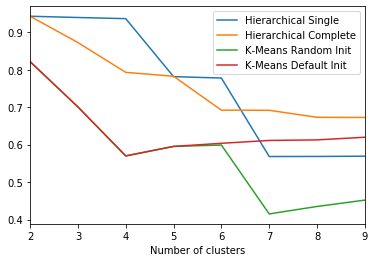

In [28]:
results = []

for i in range(2, 10):
    hierarchical_single = cluster.AgglomerativeClustering(n_clusters = i, linkage = "single")
    hierarchical_complete = cluster.AgglomerativeClustering(n_clusters = i, linkage = "complete")
    
    kmeans_random = cluster.KMeans(n_clusters = i, init = "random").fit(df)
    kmeans_default_init = cluster.KMeans(n_clusters = i).fit(df) #default init = k-means++

    hierarchical_single_clustered =  df.assign(cluster_number = hierarchical_single.fit_predict(df))
    hierarchical_complete_clustered =  df.assign(cluster_number = hierarchical_complete.fit_predict(df))
    
    kmeans_random_clustered = df.assign(cluster_number = kmeans_random.predict(df))
    kmeans_default_init_clustered = df.assign(cluster_number = kmeans_default_init.predict(df))
    
    results.append({"Number of clusters": i, 
                    "Hierarchical Single": 
                    metrics.silhouette_score(hierarchical_single_clustered, labels = hierarchical_single_clustered['cluster_number']),
                    "Hierarchical Complete":
                    metrics.silhouette_score(hierarchical_complete_clustered, labels = hierarchical_complete_clustered['cluster_number']),
                    "K-Means Random Init":
                    metrics.silhouette_score(kmeans_random_clustered, labels = kmeans_random_clustered['cluster_number']),
                    "K-Means Default Init":
                    metrics.silhouette_score(kmeans_default_init_clustered, labels = kmeans_default_init_clustered['cluster_number'])})

pd.DataFrame(results).plot.line(x = "Number of clusters",
                                y = ["Hierarchical Single", "Hierarchical Complete", "K-Means Random Init", "K-Means Default Init"])

Pela análise do gráfico acima, percebe-se que todos os algoritmos tiveram queda no valor do coeficiente 'Silhueta' conforme o número de clusters aumenta. Além disso, ambas as execuções usando o algoritmo Hierárquico tiveram desempenho superior à ambas execuções do K-Means utilizando essa métrica, sendo o Hierárquico com ligação simples melhor para um pequeno número de clusters (<= 6).

## Normalização dos dados
Normalizar os dados para reexecutar os algoritmos.

In [50]:
scaler = preprocessing.StandardScaler()

scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns.values)

scaled.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,link,photo,status,video,day,month,year,time
0,0.646104,0.323350,1.686879,0.482727,1.983266,0.196196,0.076713,0.473570,-0.155748,-0.094957,-1.245993,-0.233666,1.421466,0.832651,0.711213,-0.718661,-0.330879
1,-0.173192,-0.252206,-0.304144,-0.144720,-0.318454,-0.147879,-0.176010,-0.152587,-0.155748,-0.094957,0.802573,-0.233666,-0.703499,0.832651,0.596638,-0.718661,2.091085
2,-0.006738,0.013089,0.129017,-0.024571,0.206938,-0.033187,0.076713,-0.152587,-0.155748,-0.094957,-1.245993,-0.233666,1.421466,0.832651,0.596638,-0.718661,-0.289911
3,-0.257499,-0.252206,-0.304144,-0.231495,-0.318454,-0.147879,-0.176010,-0.152587,-0.155748,-0.094957,0.802573,-0.233666,-0.703499,0.832651,0.596638,-0.718661,-0.839371
4,-0.037003,-0.252206,-0.304144,-0.024571,-0.093286,-0.147879,-0.176010,-0.152587,-0.155748,-0.094957,0.802573,-0.233666,-0.703499,0.832651,0.252911,-0.718661,-0.711646


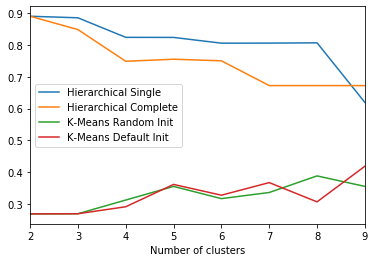

In [51]:
results_scaled = []

for i in range(2, 10):
    hierarchical_single = cluster.AgglomerativeClustering(n_clusters = i, linkage = "single")
    hierarchical_complete = cluster.AgglomerativeClustering(n_clusters = i, linkage = "complete")
    
    kmeans_random = cluster.KMeans(n_clusters = i, init = "random").fit(scaled)
    kmeans_default_init = cluster.KMeans(n_clusters = i).fit(scaled) #default init = k-means++

    hierarchical_single_clustered =  scaled.assign(cluster_number = hierarchical_single.fit_predict(scaled))
    hierarchical_complete_clustered =  scaled.assign(cluster_number = hierarchical_complete.fit_predict(scaled))
    
    kmeans_random_clustered = scaled.assign(cluster_number = kmeans_random.predict(scaled))
    kmeans_default_init_clustered = scaled.assign(cluster_number = kmeans_default_init.predict(scaled))
    
    results_scaled.append({"Number of clusters": i, 
                    "Hierarchical Single": 
                    metrics.silhouette_score(hierarchical_single_clustered, labels = hierarchical_single_clustered['cluster_number']),
                    "Hierarchical Complete":
                    metrics.silhouette_score(hierarchical_complete_clustered, labels = hierarchical_complete_clustered['cluster_number']),
                    "K-Means Random Init":
                    metrics.silhouette_score(kmeans_random_clustered, labels = kmeans_random_clustered['cluster_number']),
                    "K-Means Default Init":
                    metrics.silhouette_score(kmeans_default_init_clustered, labels = kmeans_default_init_clustered['cluster_number'])})
    
pd.DataFrame(results_scaled).plot.line(x = "Number of clusters",
                                y = ["Hierarchical Single", "Hierarchical Complete", "K-Means Random Init", "K-Means Default Init"])

A execução após a normalização apresentou resultados levemente melhores para o algoritmo Hierárquico quando o número de clusters aumenta, enquanto o K-Means caiu de performance drasticamente, contudo conforme o número de Clusters aumenta o desempenho do K-Means melhorou, porém ainda ficou abaixo do obtido com o Hierárquico.

Pelo tamanho da base de dados (7050 entradas) talvez os algoritmos tenham um desempenho diferente com um número maior de clusters do que aquilo que foi testado acima, vejamos utilizando 100 clusters:

In [63]:
hierarchical_single = cluster.AgglomerativeClustering(n_clusters = 100, linkage = "single")
hierarchical_complete = cluster.AgglomerativeClustering(n_clusters = 100, linkage = "complete")

kmeans_random = cluster.KMeans(n_clusters = 100, init = "random").fit(scaled)
kmeans_default_init = cluster.KMeans(n_clusters = 100).fit(scaled) #default init = k-means++

hierarchical_single_clustered =  scaled.assign(cluster_number = hierarchical_single.fit_predict(scaled))
hierarchical_complete_clustered =  scaled.assign(cluster_number = hierarchical_complete.fit_predict(scaled))

kmeans_random_clustered = scaled.assign(cluster_number = kmeans_random.predict(scaled))
kmeans_default_init_clustered = scaled.assign(cluster_number = kmeans_default_init.predict(scaled))

print("Sillhoutte Hierarquico Individual:", metrics.silhouette_score(hierarchical_single_clustered, labels = hierarchical_single_clustered['cluster_number']))
print("Sillhoutte Hierarquico Completo:", metrics.silhouette_score(hierarchical_complete_clustered, labels = hierarchical_complete_clustered['cluster_number']))
print("Sillhoutte K-Means aleatorio:", metrics.silhouette_score(kmeans_random_clustered, labels = kmeans_random_clustered['cluster_number']))
print("Sillhoutte K-Means padrao:", metrics.silhouette_score(kmeans_default_init_clustered, labels = kmeans_default_init_clustered['cluster_number']))

Sillhoutte Hierarquico Individual: 0.5518270033697849
Sillhoutte Hierarquico Completo: 0.5297758520210256
Sillhoutte K-Means aleatorio: 0.6248299917984553
Sillhoutte K-Means padrao: 0.6619753502317226


De fato, foram obtidos resultados melhores para o K-Means utilizando um número maior de clusters, enquanto o desempenho do Hierárquico caiu. 

Em relação ao número de clusters, os melhores desempenhos obtidos nos testes acima em todos os algoritmos foi para número de clusters igual a 2.

## Visualização dos Clusters
Nesta seção é utilizada a redução de dimensionalidade usando a análise de componentes principais (PCA) para visualizar os clusters encontrados.

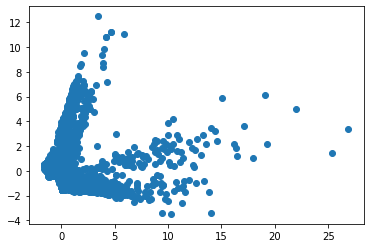

In [81]:
pca = decomposition.PCA(n_components = 2)
pca_df = pd.DataFrame(pca.fit_transform(scaled))

plt.scatter(pca_df[0], pca_df[1])

In [100]:
hierarchical_single = cluster.AgglomerativeClustering(n_clusters = 2, linkage = "single")
hierarchical_complete = cluster.AgglomerativeClustering(n_clusters = 2, linkage = "complete")

kmeans_random = cluster.KMeans(n_clusters = 2, init = "random").fit(scaled)
kmeans_default_init = cluster.KMeans(n_clusters = 2).fit(scaled) #default init = k-means++

hierarchical_single_clustered =  pca_df.assign(cluster_number = hierarchical_single.fit_predict(scaled))
hierarchical_complete_clustered =  pca_df.assign(cluster_number = hierarchical_complete.fit_predict(scaled))

kmeans_random_clustered = scaled.assign(cluster_number = kmeans_random.predict(scaled))
kmeans_default_init_clustered = scaled.assign(cluster_number = kmeans_default_init.predict(scaled))

print("Sillhoutte Hierarquico Individual:", metrics.silhouette_score(hierarchical_single_clustered, labels = hierarchical_single_clustered['cluster_number']))
print("Sillhoutte Hierarquico Completo:", metrics.silhouette_score(hierarchical_complete_clustered, labels = hierarchical_complete_clustered['cluster_number']))
print("Sillhoutte K-Means aleatorio:", metrics.silhouette_score(kmeans_random_clustered, labels = kmeans_random_clustered['cluster_number']))
print("Sillhoutte K-Means padrao:", metrics.silhouette_score(kmeans_default_init_clustered, labels = kmeans_default_init_clustered['cluster_number']))

Sillhoutte Hierarquico Individual: 0.9081390023050183
Sillhoutte Hierarquico Completo: 0.9081390023050183
Sillhoutte K-Means aleatorio: 0.2689976357300386
Sillhoutte K-Means padrao: 0.26899763573003876


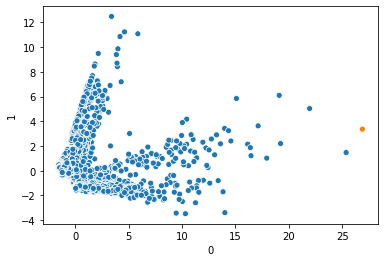

In [101]:
sns.scatterplot(x = pca_df[0], y = pca_df[1], hue = hierarchical_single_clustered['cluster_number'], legend = False)

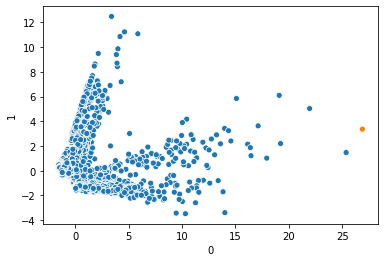

In [102]:
sns.scatterplot(x = pca_df[0], y = pca_df[1], hue = hierarchical_complete_clustered['cluster_number'], legend = False)

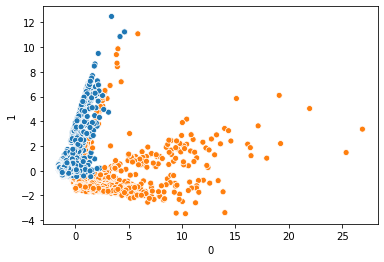

In [103]:
sns.scatterplot(x = pca_df[0], y = pca_df[1], hue = kmeans_random_clustered['cluster_number'], legend = False)

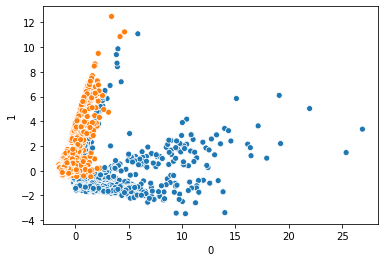

In [104]:
sns.scatterplot(x = pca_df[0], y = pca_df[1], hue = kmeans_default_init_clustered['cluster_number'], legend = False)